In [1]:
import os
os.chdir('/Users/layne/Desktop/brain_tumor_preprocessed')

In [2]:
mixed_file_paths = os.listdir('.')

In [3]:
mixed_file_paths.remove('.DS_Store')

In [4]:
len(mixed_file_paths)

80

In [5]:
from natsort import natsorted

In [6]:
mixed_file_paths = natsorted(mixed_file_paths)

---

In [7]:
import numpy as np

In [8]:
mixed_arr = []
for path in mixed_file_paths:
    if 'healthy' in path:
        arr = np.array([0,path])
    elif 'tumor' in path:
        arr = np.array([1,path])
    mixed_arr.append(arr)

In [9]:
import pandas as pd

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [10]:
df = pd.DataFrame(mixed_arr, columns=['status', 'path'])

In [11]:
df.shape

(80, 2)

In [12]:
df

,status,path
0,0,healthy_0.jpg
1,0,healthy_1.jpg
2,0,healthy_2.jpg
3,0,healthy_3.jpg
4,0,healthy_4.jpg
...,...,...
75,1,tumor_35.jpg
76,1,tumor_36.jpg
77,1,tumor_37.jpg
78,1,tumor_38.jpg


---

In [1]:
import os
os.chdir('/Users/layne/Desktop/aiqc')

In [2]:
import aiqc
from aiqc import examples

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# from importlib import reload; aiqc.delete_db(True); reload(aiqc); aiqc.create_db()

---

In [4]:
# dataset_tab = aiqc.Dataset.Tabular.from_pandas(dataframe=df, name='xray', dtype={'status':'int','path':'string'})

In [5]:
dataset_tab= aiqc.Dataset.get_by_id(1)

In [6]:
# dir_path = '/Users/layne/Desktop/brain_tumor_preprocessed'

In [7]:
# dataset_images = aiqc.Dataset.Image.from_folder(dir_path)

In [8]:
dataset_images = aiqc.Dataset.get_by_id(1)

In [9]:
# label = dataset_tab.make_label(columns=['status'])

In [10]:
label = aiqc.Label.get_by_id(1)

In [11]:
# featureset = dataset_images.make_featureset()

In [12]:
featureset = aiqc.Featureset.get_by_id(1)

In [13]:
# splitset = featureset.make_splitset(
#     label_id = label.id, 
#     size_test = 0.18, 
#     size_validation = 0.14
# )

In [14]:
splitset = aiqc.Splitset.get_by_id(4)

---

In [15]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import History
from keras.callbacks import Callback
from keras.layers import Conv1D, Dense, Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [17]:
def function_model_build(**hyperparameters):
    model = Sequential()
    
    model.add(Conv1D(128*hyperparameters['neuron_multiply'], kernel_size=hyperparameters['kernel_size'], input_shape=(160,120), padding='same', activation='relu', kernel_initializer=hyperparameters['cnn_init']))
    model.add(MaxPooling1D(pool_size=hyperparameters['pool_size']))
    model.add(Dropout(hyperparameters['dropout']))
    
    model.add(Conv1D(256*hyperparameters['neuron_multiply'], kernel_size=hyperparameters['kernel_size'], padding='same', activation='relu', kernel_initializer=hyperparameters['cnn_init']))
    model.add(MaxPooling1D(pool_size=hyperparameters['pool_size']))
    model.add(Dropout(hyperparameters['dropout']))

    model.add(Flatten())
    model.add(Dense(hyperparameters['dense_neurons']*hyperparameters['neuron_multiply'], activation='relu'))
    model.add(Dropout(0.2))
    if hyperparameters['include_2nd_dense'] == True:
        model.add(Dense(hyperparameters['2nd_dense_neurons'], activation='relu'))
        #model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adamax(hyperparameters['learning_rate'])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):   
    
#     class EarlyStopper(Callback):
#         def __init__(self, metric_1='val_accuracy', metric_2='accuracy', threshold=0.90):
#             super(EarlyStopper, self).__init__()
#             self.metric_1 = metric_1
#             self.metric_2 = metric_2
#             self.threshold = threshold

#         def on_epoch_end(self, epoch, logs=None):
#             logs = logs or {}
#             metric_1 = logs.get(self.metric_1)
#             metric_2 = logs.get(self.metric_2)
#             if ((metric_1 is not None) and (metric_2 is not None)):
#                 if (('accuracy' in self.metric_1) and ('accuracy' in self.metric_2)): 
#                     if ((metric_1 >= self.threshold) and (metric_2 >= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nExceeded '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                         os.system("say bingo")
#                 elif (('loss' in self.metric_1) and ('loss' in self.metric_2)):
#                     if ((metric_1 <= self.threshold) and (metric_2 <= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nCross below '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                 elif (('loss' in self.metric_1) and ('accuracy' in self.metric_2)):
#                     if ((metric_1 <= self.threshold) and (metric_2 >= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nSatisfied '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
#                 elif (('accuracy' in self.metric_1) and ('loss' in self.metric_2)):
#                     if ((metric_1 >= self.threshold) and (metric_2 <= self.threshold)):
#                         print(f"\n:: Epoch #{epoch} ::\nSatisfied '{self.metric_1}' and '{self.metric_2}' thresholds. Stopped training early.\n")
#                         self.model.stop_training = True
    
#     model.fit(
#         samples_train["features"]
#         , samples_train["labels"]
#         , validation_data = (
#             samples_evaluate["features"]
#             , samples_evaluate["labels"]
#         )
#         , verbose = 0
#         , batch_size = hyperparameters['batch_size']
#         , callbacks=[History(), EarlyStopper()]
#         , epochs = hyperparameters['epoch_count']
#     )

#     return model

In [33]:
def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):   
    
    metrics_cuttoffs = [
        {"metric":"val_accuracy", "cutoff":0.70, "above_or_below":"above"},
        {"metric":"accuracy", "cutoff":0.70, "above_or_below":"above"},
        {"metric":"val_loss", "cutoff":0.50, "above_or_below":"below"},
        {"metric":"loss", "cutoff":0.50, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hyperparameters['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hyperparameters['epoch_count']
    )

    return model

In [34]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "classification_binary"
    , function_model_build = function_model_build
    , function_model_train = function_model_train
)

In [35]:
hyperparameters = {
    "include_2nd_dense": [True]
    , "neuron_multiply": [1.0] # 1 edging past 0.5
    , "epoch_count": [300, 400] #300
    , "learning_rate": [0.01] #consistent.
    , "pool_size": [2]
    , "dropout": [0.4] #0.3 did well too.
    , "batch_size": [8] #8 did best. tried 5 and 6 again, no.
    , "kernel_size": [3]
    , "dense_neurons": [64] # 64 beat 32.
    , "2nd_dense_neurons": [24, 16] #16 beat 8.
    , "cnn_init": ['he_normal', 'he_uniform'] #default is glorot
}

In [36]:
#batch 47 job 271. test	0.958333, train	1.000000
#b47 = aiqc.Batch.get_by_id(47)

#batch 67 w validation but low 90s train val | test 86 acc

In [37]:
hyperparamset = aiqc.Hyperparamset.from_algorithm(
    algorithm_id = algorithm.id
    , hyperparameters = hyperparameters
)

In [38]:
batch = aiqc.Batch.from_algorithm(
    algorithm_id = algorithm.id
    , splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
)

In [39]:
batch.run_jobs()

🔮 Training Models 🔮:   0%|                                                  | 0/8 [00:00<?, ?it/s]


:: Epoch #61 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  12%|█████▎                                    | 1/8 [00:08<00:59,  8.46s/it]


:: Epoch #133 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  38%|███████████████▊                          | 3/8 [00:53<01:21, 16.30s/it]


:: Epoch #84 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  50%|█████████████████████                     | 4/8 [01:03<00:57, 14.47s/it]


:: Epoch #320 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  62%|██████████████████████████▎               | 5/8 [01:37<01:00, 20.21s/it]


:: Epoch #48 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  75%|███████████████████████████████▌          | 6/8 [01:44<00:32, 16.18s/it]


:: Epoch #195 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮:  88%|████████████████████████████████████▊     | 7/8 [02:04<00:17, 17.43s/it]


:: Epoch #159 ::
Satisfied thresholds defined in MetricCutoff callback. Stopped training early.



🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 8/8 [02:21<00:00, 17.72s/it]


In [41]:
batch.statuses_to_pandas()

,job_id,status
0,630,Queued
1,631,Queued
2,632,Queued
3,633,Queued
4,634,Queued
5,635,Queued
6,636,Queued
7,637,Queued


In [887]:
batch.metrics_to_pandas()

,job_id,split,accuracy,f1,loss,precision,recall,roc_auc
0,566,test,0.466667,0.428571,2.723680,0.428571,0.428571,0.500000
1,566,validation,0.583333,0.444444,3.101817,0.666667,0.333333,0.513889
2,566,train,0.792453,0.744186,0.385467,1.000000,0.592593,0.843305
3,567,test,0.600000,0.625000,1.831132,0.555556,0.714286,0.723214
4,567,validation,0.500000,0.500000,2.238493,0.500000,0.500000,0.541667
5,567,train,0.905660,0.901961,0.219649,0.958333,0.851852,0.975783
6,568,test,0.800000,0.823529,1.084532,0.700000,1.000000,0.839286
7,568,validation,0.916667,0.923077,0.557437,0.857143,1.000000,0.972222
8,568,train,0.981132,0.981132,0.062419,1.000000,0.962963,0.998575
9,569,test,0.666667,0.666667,2.911098,0.625000,0.714286,0.714286


In [863]:
aiqc.Job.get_by_id(409).hyperparamcombo.hyperparameters_to_pandas() #90+ accurate.

,param,value
0,include_2nd_dense,True
1,neuron_multiply,1
2,epoch_count,400
3,learning_rate,0.01
4,pool_size,2
5,dropout,0.4
6,batch_size,6
7,kernel_size,3
8,dense_neurons,64
9,2nd_dense_neurons,16


In [883]:
aiqc.Job.get_by_id(570).hyperparamcombo.hyperparameters_to_pandas() #90+ accurate.

,param,value
0,include_2nd_dense,True
1,neuron_multiply,1
2,epoch_count,400
3,learning_rate,0.01
4,pool_size,2
5,dropout,0.4
6,batch_size,8
7,kernel_size,3
8,dense_neurons,64
9,2nd_dense_neurons,24


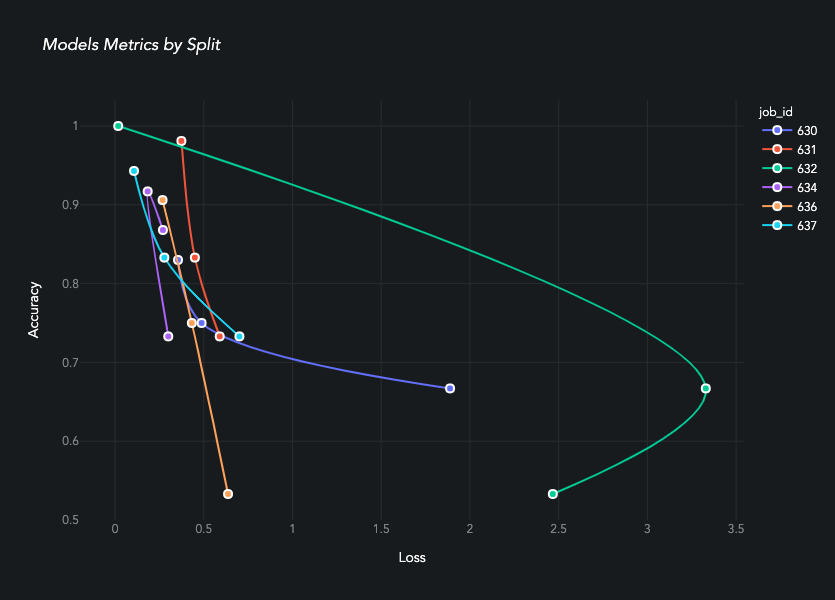

In [44]:
batch.plot_performance(max_loss=15, min_metric_2=0.5)

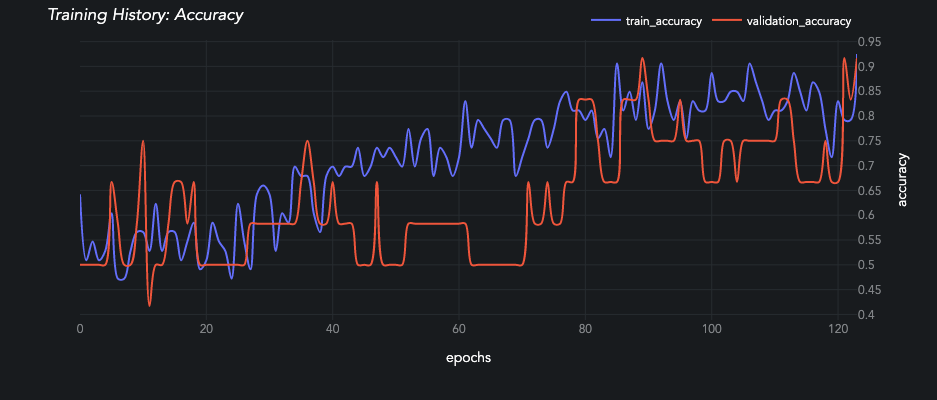

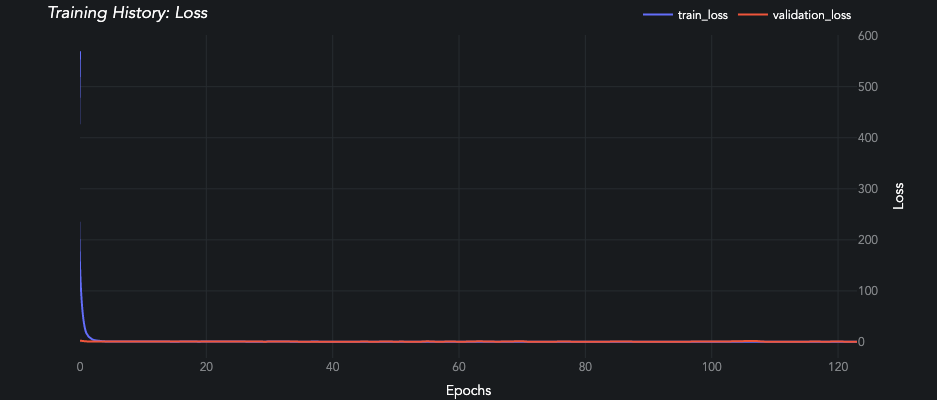

In [830]:
aiqc.Job.get_by_id(503).results[0].plot_learning_curve()

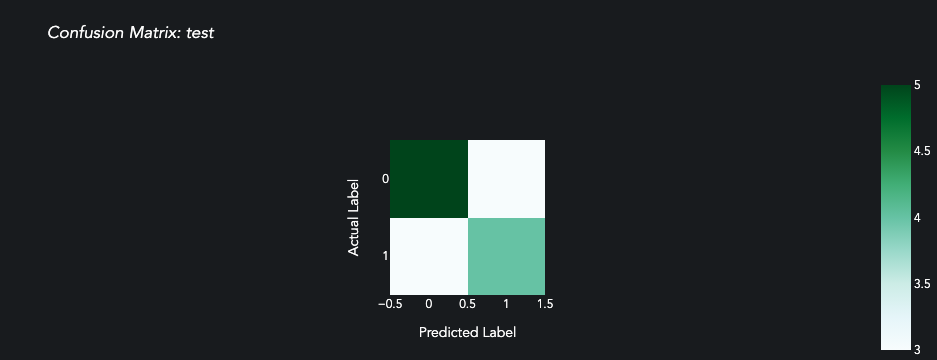

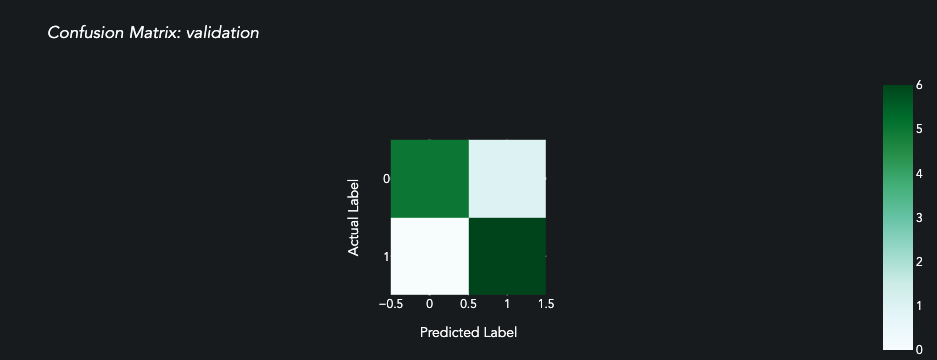

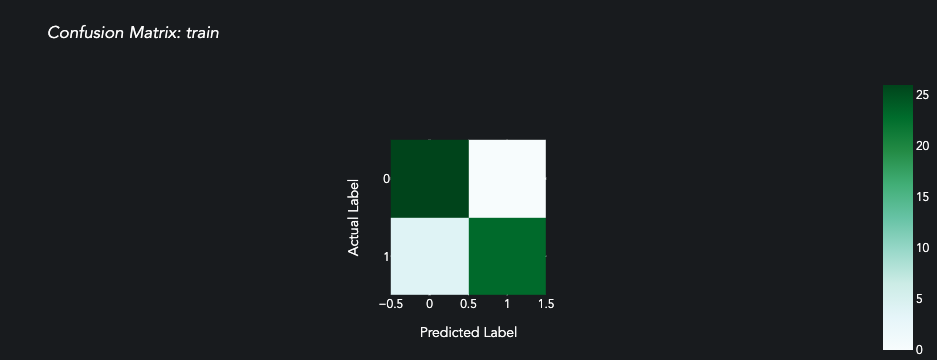

In [831]:
aiqc.Job.get_by_id(503).results[0].plot_confusion_matrix()

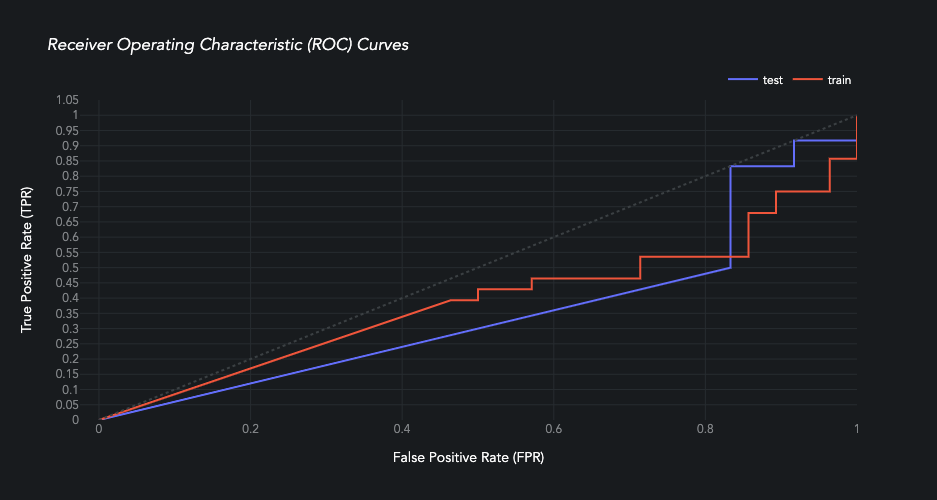

In [53]:
aiqc.Job.get_by_id(4).results[0].plot_roc_curve()